# Part 2 - Extracting Audio Features



## Introduction 
#### To understand the various features we can extract from audio, and use it to predict gender and accents


In part 2 of this series, I'll introduce the various types of features from audio and we can see how these features differ when we compare between genders and accent types. I'm hoping one of these features will be distinctive enough that we could use it for predictive modelling in the next part. 

I would also like to acknowledge 2 people whom I've learnt alot from: 
- __[Jayesh Saita](https://towardsdatascience.com/ok-google-how-to-do-speech-recognition-f77b5d7cbe0b)__, whose blog I really liked and helped me understand audio features and MFCCs in the early stages of my journey   
- __[Zafarullah Mahmood](https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data)__, whose Kaggle Kernel basically became the canvas for all audio work that I do at work and outside work. Please do check out his kernels whom I've drawn lots of inspiration from! 

This part 2 kernel will cover quite a few items so I'll provide a brief agenda: 
- [Core concepts in Audio](#core)
- [Time domain features](#time) 
    - [1. Audio wave](#time)
- [Frequency domain features](#mfcc)
    - [2. MFCC](#mfcc)
    - [3. Log Mel-spectogram](#melspec)
    - [4. Harmonic-percussive source separation (HPSS)](#hpss)
    - [5. Chroma](#chroma)
- [Final thoughts](#final)

Again, thanks to the awesome Kaggle community, and the broader data science community. Without further ado, lets begin!

In [3]:
import pandas as pd       
import os 
import math 
import numpy as np
import matplotlib.pyplot as plt  
import IPython.display as ipd  # To play sound in the notebook
import librosa
import librosa.display

In [6]:
recordings_path = "/home/bithika/reSpeecher_voice_conversion/data/raw/speech-accent-archive/recordings"

In [8]:
os.chdir(recordings_path)

------------------------------
After loading the libraries and setting our directory path, we're going to use the two Kentucky accent speakers 

In [9]:
# Play female from Kentucky
fname_f = 'recordings/' + 'english385.mp3'   
ipd.Audio(fname_f)

In [10]:
# Play male from Kentucky
fname_m = 'recordings/' + 'english381.mp3'
ipd.Audio(fname_m)

<a id="core"></a>
##  Core concepts in Audio

Before diving straight to the meaty bits, I'm going to quickly introduce a few key concepts to anyone who's new to audio 
- Duration
- sampling rate
- Amplitude 
- Frequency


__Duration__ is the length of the audio call in terms of time. 

__Sampling rate__ is the number of samples of audio per second, measured in Hz / KHz. This is similar to resolution in images, where the higher the resolution (or more pixels), the clearer it is. A full sampling rate is 44100 Hz (44.1 KHz) but, you don't always need to have it in at 'High Fidelity' format. A more reasonable sampling rate is 22050 Hz (22 KHz), because that is the audible sound to a human. 

__Amplitude__ is the fluctuation of the soud wave. The shorter and more frequent the waves are, the higher the pitch or frequency. Plotting the audio by time against amplitute is probably the most intuitive way of understanding the audio. However, its not the only way to represent the data or used as feature. Another equally good way of doing this is to look at it by the frequency domain, which is a nice segway to our final concept. 

__Frequency__, the best way of understanding it is through visualising it. Imagining the audio in terms of time is probably the most intutive way of thinking about it. But frequency, although not as intuitive, is actually much more efficient as signal in the frequency domain requires much less computational space for storage. Below is a nice visualisation of how to differentiate the Time vs Frequency domain

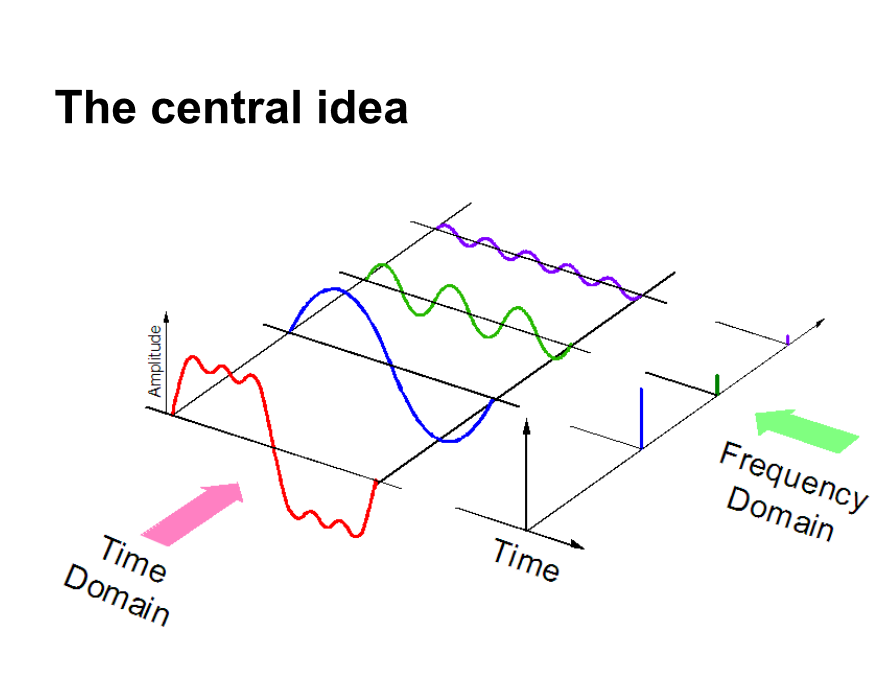
The time vs frequency domain sourced from __[here](https://docs.google.com/presentation/d/1zzgNu_HbKL2iPkHS8-qhtDV20QfWt9lC3ZwPVZo8Rw0/pub?start=false&loop=false&delayms=3000&slide=id.g5a7a9806e_0_84)__ 

So what we're going to do is use the same audio file but plot the 2 different sampling rates to see how they differ, one at the full 44100 Hz and the other at 6000 Hz. We're also going to down sample them and chop the audio file at 5 seconds just so the differences are more perceptible

<a id="time"></a>
## 1. Audio wave

Audio wave is our first feature. This is of course the first most common form of the data, and is the only time domain feature that I am aware off. Lets use this opportunity to plot the two audio files again at their most native format, which is the wave form. To start off, I'm going to plot them in 3 different sampling rates, at 44kHz, 6kHz and 1000kHz and see how they differ, using the female version of the audio (_fname = english385.mp3_)

Note that I'm only taking the first 5 seconds of audio for illustration purposes.

/home/bithika/local/anaconda3/envs/pytorch_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Text(0.5, 1.0, 'Audio sampled at 44100 Hz')

<Figure size 864x216 with 0 Axes>

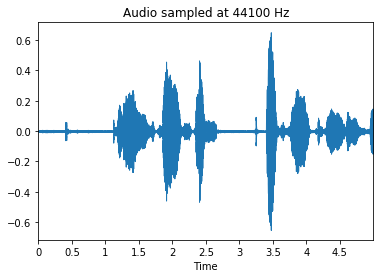

In [17]:
# The full 'high fidelity' sampling rate of 44k 
SAMPLE_RATE = 44100
fname_f = 'recordings/' + 'english385.mp3' 
y, sr = librosa.load(fname_f, sr=SAMPLE_RATE, duration = 5)

plt.figure(figsize=(12, 3))
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('Audio sampled at 44100 Hz')

/home/bithika/local/anaconda3/envs/pytorch_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Text(0.5, 1.0, 'Audio sampled at 6000 Hz')

<Figure size 864x216 with 0 Axes>

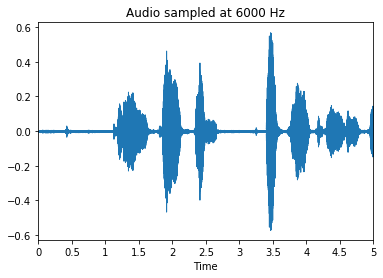

In [15]:
# The very 'low fidelity' sampling rate of 6k 
SAMPLE_RATE = 6000
fname_f = 'recordings/' + 'english385.mp3' 
y, sr = librosa.load(fname_f, sr=SAMPLE_RATE, duration = 5)

plt.figure(figsize=(12, 3))
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('Audio sampled at 6000 Hz')

/home/bithika/local/anaconda3/envs/pytorch_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Text(0.5, 1.0, 'Audio sampled at 1000 Hz')

<Figure size 864x216 with 0 Axes>

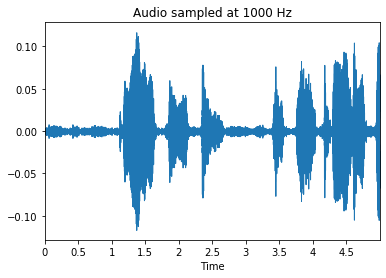

In [18]:
# The very very 'low fidelity' sampling rate of 1k 
SAMPLE_RATE = 1000
fname_f = 'recordings/' + 'english385.mp3' 
y, sr = librosa.core.load(fname_f, sr=SAMPLE_RATE, duration = 5)

plt.figure(figsize=(12, 3))
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('Audio sampled at 1000 Hz')

Note the minor differences between the 44100 Hz and the 6000 Hz? Things start to change once you go down to sampling rate of 1000 Hz, and audio becomes more blurry. Generally 21500 Hz sampling rate is the most common as previously mentioned. And the difference with 44 KHz is very minor. For now, we're going to use a sampling rate of 6000 Hz, to compare the male and female speakers from Kentucky. 

Since we've plotted the female version, lets hear the male version now (_fname = english381.mp3_)... at 6000 Hz and chopped at 5 seconds. You can see has some distinctive pattern over the female equivalent

/home/bithika/local/anaconda3/envs/pytorch_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Text(0.5, 1.0, 'Audio sampled at 6000 Hz')

<Figure size 864x216 with 0 Axes>

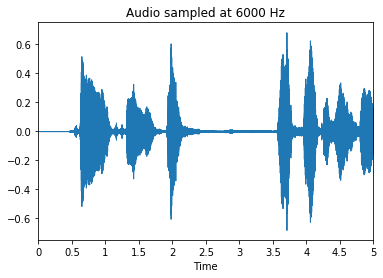

In [19]:
# The 'low fidelity' sampling rate of 6k 
SAMPLE_RATE = 6000
fname_m = 'recordings/' + 'english381.mp3' 
y, sr = librosa.load(fname_m, sr=SAMPLE_RATE, duration = 5)

plt.figure(figsize=(12, 3))
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('Audio sampled at 6000 Hz')

There's some distinctive differences in the wave pattern between male and female but we don't really know what information it is capturing. It could be capturing the supposedly higher pitch voice that female has, or it could just be the different accent pronoucation between the 2 speakers. And that's why we use machine learning right? 

I suppose if there's one thing that's clear between the 2 audio file is that, the male speaker seems to have a more consistent pitch overtime versus the female counter part, whom we can clearly see an obvious huge spike in amplitude. 

<a id="mfcc"></a>
## 2. MFCC
Now moving into the Frequency domain feature, this is my favourite which is MFCC, short for Mel-Frequency Cepstral Coefficient. MFCC is a sentence, is a "representation" of the vocal tract that produces the sound. Think of it like an x-ray of your mouth. The processing steps to get MFCC is quite lengthy but  in my simple mind, that is how I understand it. A more indepth and technical explanation can be found __[here](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)__. 

So we're now going to compare males and female voices via the MFCC coefficient plots

/home/bithika/local/anaconda3/envs/pytorch_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


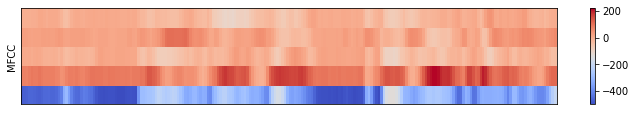

In [21]:
# MFCC for female 
SAMPLE_RATE = 22050
fname_f = 'recordings/' + 'english385.mp3'  
y, sr = librosa.load(fname_f, sr=SAMPLE_RATE, duration = 5) # Chop audio at 5 secs... 
mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc = 5) # 5 MFCC components

plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

/home/bithika/local/anaconda3/envs/pytorch_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


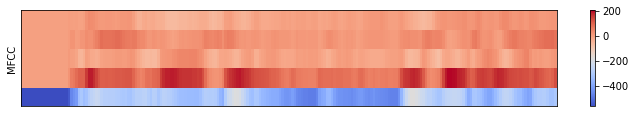

In [22]:
# MFCC for male  
SAMPLE_RATE = 22050
fname_m = 'recordings/' + 'english381.mp3'  
y, sr = librosa.load(fname_m, sr=SAMPLE_RATE, duration = 5)
mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc = 5)

plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

Notice the difference? Seems like there could be something here. Generally in practice one would use not just the entire duration of the audio, but also set a higher number of MFCC components, usually between 20 and 40. Here I used 5 MFCC components just so its easier to visualise the difference. We will use the optimal settings later in the actual modelling component. In my limited experience so far with audio, I have gotten the most success in using MFCC as the feature choice for supervise learning

<a id="melspec"></a>
## 3. Log Mel-spectogram

Other than MFCC, the next most popular, if not the most popular audio feature is the Mel-spectogram. A time by frequency representation of the audio wave form is called a spectogram. That spectogram is then mapped to the Mel-scales thus giving us the Mel-spectogram. But because human perception of sound intensity is logarithmic in nature, the log form of the Mel-spectogram is the better one in theory. Thou I admit I haven't research this in alot of depth. 

Like MFCC, Log Mel-spectogram are well known to be discriminative features in audio. So once again, lets see how the Log Mel-spectogram varies between male and female.

/home/bithika/local/anaconda3/envs/pytorch_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


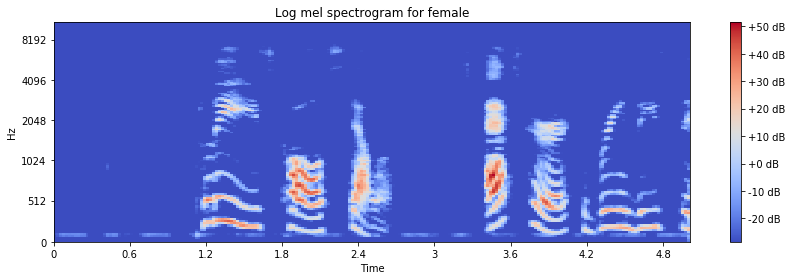

In [23]:
# Log Mel-spectogram for female 
SAMPLE_RATE = 22050
fname_f = 'recordings/' + 'english385.mp3'  
y, sr = librosa.load(fname_f, sr=SAMPLE_RATE, duration = 5) # Chop audio at 5 secs... 
melspec = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.amplitude_to_db(melspec)

# Display the log mel spectrogram
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Log mel spectrogram for female')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

/home/bithika/local/anaconda3/envs/pytorch_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


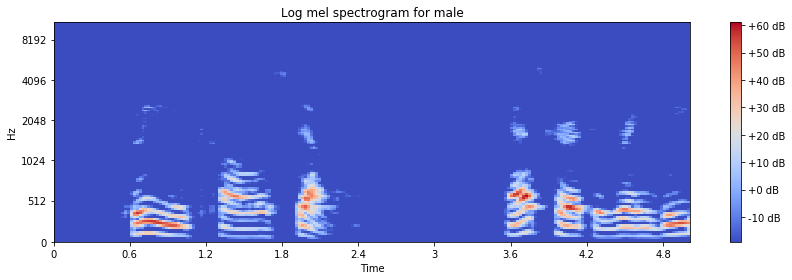

In [24]:
# Log Mel-spectogram for male 
SAMPLE_RATE = 22050
fname_m = 'recordings/' + 'english381.mp3'  
y, sr = librosa.load(fname_m, sr=SAMPLE_RATE, duration = 5) # Chop audio at 5 secs... 
melspec = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.amplitude_to_db(melspec)

# Display the log mel spectrogram
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Log mel spectrogram for male')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

The difference may not be as obvious but is definitely noticable after careful inspection. In particular, the female version  reaches a higher frequency compared to the male counterpart. 

I've also heard about a Mel Power spectogram as another feature, thou I haven't had any experience using it, hence I really can't comment how good it is compared to a Log Mel spectogram. Perhaps someone else who's a real expert can elaborate further. Leave the comments down below!

<a id="hpss"></a>
## 4. Harmonic-percussive source separation

Its a mouthful to pronounce, but it's really easy to remember and I rarely use its short form of HPSS. Despite the complex description, it is essentially quite literal in what it means. This feature seperates the harmonic and the percussive source of an audio file. There's a really good notebook that explains how this works __[here](https://musicinformationretrieval.com/hpss.html)__

Lets take one of the audio files and __seperate its harmonic and perussive source__ (see told you its easy to remember), then listen to it too see how different they are...

In [25]:
SAMPLE_RATE = 22050
fname_f = 'recordings/' + 'english385.mp3'  
y, sr = librosa.load(fname_f, sr=SAMPLE_RATE, duration = 5) 
y_harmonic, y_percussive = librosa.effects.hpss(y)

ipd.Audio(y_harmonic, rate=sr)

/home/bithika/local/anaconda3/envs/pytorch_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [26]:
ipd.Audio(y_percussive, rate=sr)

It's a pity that playing these audio files aren't the best way to really get a feel for how different the harmonic and percussive source sounds like. Generally its really obvious for music as it seperates out the beats from drums. In either case, maybe converting the source to a Mel spectogram may shed abit more light...

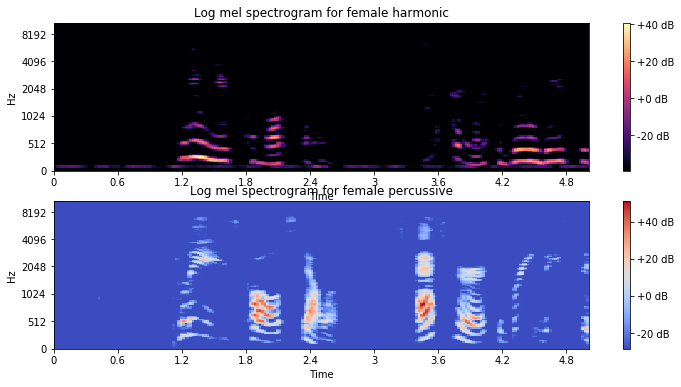

In [27]:
# harmonic 
melspec = librosa.feature.melspectrogram(y_harmonic, sr=sr, n_mels=128)
log_h = librosa.amplitude_to_db(melspec)

# percussive
melspec = librosa.feature.melspectrogram(y_percussive, sr=sr, n_mels=128)
log_p = librosa.amplitude_to_db(melspec)

# Display the log mel spectrogram of both harmonic and percussive
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
librosa.display.specshow(log_h, sr=sr, x_axis='time', y_axis='mel')
plt.title('Log mel spectrogram for female harmonic')
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_p, sr=sr, x_axis='time', y_axis='mel')
plt.title('Log mel spectrogram for female percussive')
plt.colorbar(format='%+02.0f dB')

Here's another alternative way to go about getting HPSS which is the decompose route. Output's the same but just a shortcut

In [28]:
# Lets use this one for the male 
SAMPLE_RATE = 22050
fname_f = 'recordings/' + 'english381.mp3'  
y, sr = librosa.load(fname_f, sr=SAMPLE_RATE, duration = 5)
X = librosa.stft(y)
H, P = librosa.decompose.hpss(X)  # Both Harmonic and Percussive as spectogram 
Hmag = librosa.amplitude_to_db(H) # Get log mel-spectogram 
Pmag = librosa.amplitude_to_db(P)

# Have a listen to male harmonic 
h = librosa.istft(H)
ipd.Audio(h, rate=SAMPLE_RATE)

/home/bithika/local/anaconda3/envs/pytorch_gpu/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/bithika/local/anaconda3/envs/pytorch_gpu/lib/python3.7/site-packages/librosa/core/spectrum.py:1702: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


In [29]:
# Have a listen to male percussive 
p = librosa.istft(P)
ipd.Audio(p, rate=SAMPLE_RATE)

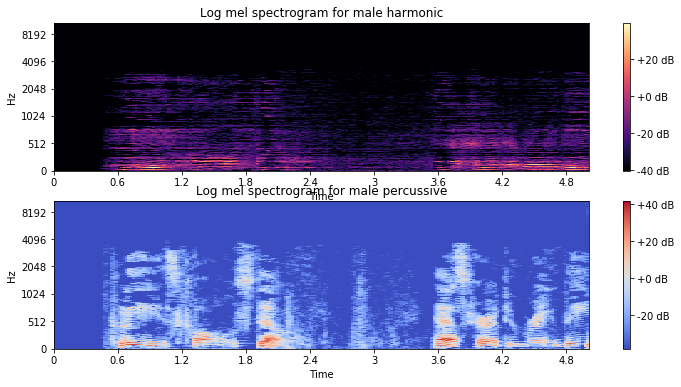

In [30]:
# Display the log mel spectrogram of both harmonic and percussive
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
librosa.display.specshow(Hmag, sr=sr, x_axis='time', y_axis='mel')
plt.title('Log mel spectrogram for male harmonic')
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(Pmag, sr=sr, x_axis='time', y_axis='mel')
plt.title('Log mel spectrogram for male percussive')
plt.colorbar(format='%+02.0f dB')

Notice how the HPSS for both female and male are quite diffferent? It sort of looks like the male version is abit rough? I'm no expert in interpreting the outputs of the HPSS but safe to say it will serve as a good feature for the machine learning model

<a id="chroma"></a>
## 5. Chroma

This feature is still pretty new to me. But the way I understand it is that it classifies the pitches into 12 distinct classes called 'pitch profiles. Often used in music but again, I haven't done much research on this feature and have never tried it on a deep learning architecture before, at least not yet. I'll aim to give this a try in this series! 

But before we do, lets compare how female and male differs in Chroma

In [ ]:
SAMPLE_RATE = 22050
fname_f = 'recordings/' + 'english381.mp3'  
y, sr = librosa.load(fname_f, sr=SAMPLE_RATE, duration = 5)
C = librosa.feature.chroma_cqt(y=y, sr=sr)

# Make a new figure
plt.figure(figsize=(12,4))
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
plt.title('Chromagram')
plt.colorbar()
plt.tight_layout()

In [ ]:
SAMPLE_RATE = 22050
fname_f = 'recordings/' + 'english385.mp3'  
y, sr = librosa.load(fname_f, sr=SAMPLE_RATE, duration = 5)
C = librosa.feature.chroma_cqt(y=y, sr=sr)

# Make a new figure
plt.figure(figsize=(12,4))
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
plt.title('Chromagram')
plt.colorbar()
plt.tight_layout()

Quite surprisingly, Chroma seems to be the most discriminative feature between male and female, or at least visually. We should definitely try and use Chroma for our deep learning.  

------------------------------
<a id="final"></a>
## Final thoughts

And there you have it! The 5 features you can extract from audio. Note that there are more features you can extract such as Beat Tracking, spectogram, spectral informations and etc. But I'm not familiar with them. So I'll let the experts elaborate on those other features.

Now moving on, part 3 we will go into the actual modelling. First up, I will show how you could use the traditional machine learning models first such as Gradient Boosting and Random Forest, before jumping into deep learning. Then at Part 4 we'll go into Deep Learning. 

Stay Tuned!